### rice 분류

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as img
import plotly.graph_objects as go
import pathlib
import os
import copy
import random
import time
from random import randint
from PIL import Image
from IPython.display import HTML
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset , DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from torch.autograd import Variable
import cv2
import os
import glob

In [14]:
DataPath = "c:/workspace3/data/images/Rice_Image_Dataset/"

dic = {'Arborio': 0, 'basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

device = "cuda"

fname=[]
limit =500
path=[]

for name in glob.glob(DataPath+"*[!.txt]"):
#                               * : 모든
    temp=0

    for filename in os.listdir(name):  
        if temp >= limit:
            break
        fname.append(filename)
        path.append(name)

        temp = temp+1

In [15]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(100),
    transforms.ToTensor(),
])

In [16]:
class RiceData(Dataset):
    def __init__(self, filename , root):
        self.filename = filename
        self.root = root

    def __getitem__(self, index):
        path = self.root[index]
        direct = self.filename[index].split(' ')[0]
        filename = self.filename[index]
        label = dic[direct]

        img = cv2.imread(f"{path}/{filename}")
        img = transform(img)

        return img, label

    def __len__(self):
        return len(self.filename)    

train_ds = RiceData(fname, root=path)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
dataiter = iter(train_dl)
data = next(dataiter)
img, labels = data

print(img, labels)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [17]:
test_split = 0.2  
shuffle_dataset = True
random_seed = 1234
dataset_size = len(train_ds)

indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
#               버림
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(train_ds, batch_size=1, sampler=train_sampler)
test_loader = DataLoader(train_ds, batch_size=1, sampler=test_sampler)

dataiter = train_loader.__iter__()
data = dataiter.__next__()

img, labels = data

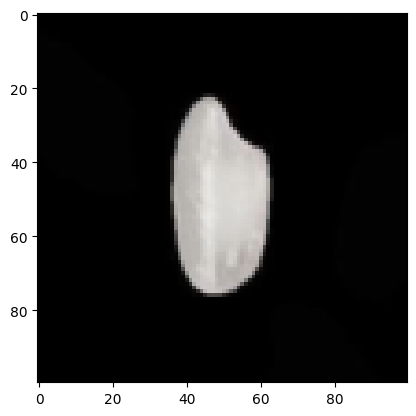

In [18]:
img = img[0].swapaxes(0, 1)
#             축 변경
img = img.swapaxes(1, 2)

plt.imshow(img)
plt.show()

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 25 * 25)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [20]:
model = CNN()
optimizer = optim.Adam(model.parameters())

for epoch in range(2):
    for i, (images, labels) in enumerate(train_loader):
#                              제너레이터
        optimizer.zero_grad()
        output = model(images)

        loss = nn.functional.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [1/400], Loss: 1.5606
Epoch [1/10], Step [101/400], Loss: 0.0000
Epoch [1/10], Step [201/400], Loss: 0.0000
Epoch [1/10], Step [301/400], Loss: 0.0000
Epoch [2/10], Step [1/400], Loss: 0.0000
Epoch [2/10], Step [101/400], Loss: 0.0000
Epoch [2/10], Step [201/400], Loss: 0.0000
Epoch [2/10], Step [301/400], Loss: 0.0000


In [21]:
correct = 0
total = 0

with torch.no_grad():
    try:
        for images , labels in test_loader:
            #print(labels.numpy())
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    except:
        pass
      
print (correct/total)

1.0
